In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from scipy import stats

import warnings
warnings.filterwarnings('ignore')

In [2]:
pip install holidays

Note: you may need to restart the kernel to use updated packages.


In [3]:
import holidays
from datetime import date

## Загрузка данных

In [4]:
sales = pd.read_csv('/Users/dariadzhioeva/Desktop/sp_sales_task/sales_df_train.csv')
goods = pd.read_csv('/Users/dariadzhioeva/Desktop/sp_sales_task/pr_df.csv')
submissions = pd.read_csv('/Users/dariadzhioeva/Desktop/sp_sales_task/sales_submission.csv') 
stores = pd.read_csv('/Users/dariadzhioeva/Desktop/sp_sales_task/st_df.csv')
holidays = pd.read_csv('/Users/dariadzhioeva/Desktop/sp_sales_task/holidays_covid_calendar.csv')

In [5]:
sales

,st_id,pr_sku_id,date,pr_sales_type_id,pr_sales_in_units,pr_promo_sales_in_units,pr_sales_in_rub,pr_promo_sales_in_rub
0,c81e728d9d4c2f636f067f89cc14862c,c7b711619071c92bef604c7ad68380dd,2022-10-20,1,5.0,5.0,825.0,825.0
1,42a0e188f5033bc65bf8d78622277c4e,68f441429e73dbd33b81f95da31576e9,2023-01-29,0,4.0,0.0,196.0,0.0
2,1ecfb463472ec9115b10c292ef8bc986,22988026fe85fde60d8bf777ab6bc3b4,2023-03-02,0,1.0,0.0,78.0,0.0
3,42a0e188f5033bc65bf8d78622277c4e,8e887cf8e64ab8e7173701a979476567,2023-04-05,1,0.0,0.0,69.0,69.0
4,16a5cdae362b8d27a1d8f8c7b78b4330,e6fc24ca846339d204b0b50e9f772484,2023-02-17,0,1.0,0.0,161.0,0.0
...,...,...,...,...,...,...,...,...
883010,c81e728d9d4c2f636f067f89cc14862c,a0150fefa71d6606d5e642fa0e7b8ad8,2022-12-13,1,1.0,1.0,33.0,33.0
883011,42a0e188f5033bc65bf8d78622277c4e,5b146d93f822459260216df28e572eca,2023-04-18,0,1.0,0.0,192.0,0.0
883012,42a0e188f5033bc65bf8d78622277c4e,c8bd18ea08d2f47cb0a7992f11ada9de,2022-08-16,0,5.0,0.0,970.0,0.0
883013,f7e6c85504ce6e82442c770f7c8606f0,b960c6ee5b5efa12e73f810204b561a8,2023-04-23,0,4.0,0.0,262.0,0.0


In [6]:
sales.describe()

,pr_sales_type_id,pr_sales_in_units,pr_promo_sales_in_units,pr_sales_in_rub,pr_promo_sales_in_rub
count,883015.000000,883015.000000,883015.000000,883015.000000,883015.000000
mean,0.406486,5.037956,2.230010,596.705181,294.766561
std,0.491178,13.402984,11.063288,1577.366179,1402.764168
min,0.000000,-39.000000,-39.000000,-3373.000000,-3373.000000
25%,0.000000,1.000000,0.000000,98.000000,0.000000
50%,0.000000,2.000000,0.000000,224.000000,0.000000
75%,1.000000,4.000000,1.000000,540.000000,127.000000
max,1.000000,2348.000000,2348.000000,183265.000000,183265.000000


В данных существуют отрицательные значения: после уточнения у бизнеса, эти данные – возврат товара или товар под списывание. Наблюдаем в данных вариабельность. Очевидно, что есть выбросы.

In [7]:
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 883015 entries, 0 to 883014
Data columns (total 8 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   st_id                    883015 non-null  object 
 1   pr_sku_id                883015 non-null  object 
 2   date                     883015 non-null  object 
 3   pr_sales_type_id         883015 non-null  int64  
 4   pr_sales_in_units        883015 non-null  float64
 5   pr_promo_sales_in_units  883015 non-null  float64
 6   pr_sales_in_rub          883015 non-null  float64
 7   pr_promo_sales_in_rub    883015 non-null  float64
dtypes: float64(4), int64(1), object(3)
memory usage: 53.9+ MB


Перед нами стоит задача временных рядов, но данные с датой неверного типа

In [8]:
#sales['date'] = pd.to_datetime(sales['date'])
#sales.set_index('date', inplace=True)
#sales.info()
sales['dates'] = sales['date'].copy()
sales['date'] = pd.to_datetime(sales['date'])
sales = sales.set_index('date') 

In [9]:
pd.DataFrame(round(sales.isna().mean()*100,)).style.background_gradient('coolwarm')

,0
st_id,0.000000
pr_sku_id,0.000000
pr_sales_type_id,0.000000
pr_sales_in_units,0.000000
pr_promo_sales_in_units,0.000000
pr_sales_in_rub,0.000000
pr_promo_sales_in_rub,0.000000
dates,0.000000


In [10]:
cols = ["pr_sales_in_units", "pr_promo_sales_in_units", "pr_sales_in_rub", "pr_promo_sales_in_rub"]

# Подсчитываем количество отрицательных значений
negative_values = sales[cols].apply(lambda x: x < 0).sum()
negative_values = negative_values / len(sales) * 100
print(round(negative_values,3))

pr_sales_in_units          0.008
pr_promo_sales_in_units    0.004
pr_sales_in_rub            0.009
pr_promo_sales_in_rub      0.004
dtype: float64


Процент отрицательных значений минимальный, для прогнозирования нам не нужны возвраты товаров. Удаляем 

In [11]:
sales.shape

(883015, 8)

In [12]:
sales = sales.loc[(sales[cols] >= 0).all(axis=1)]
sales.shape

(882936, 8)

Отрицательные значения удалены успешно. Построим correlation matrix

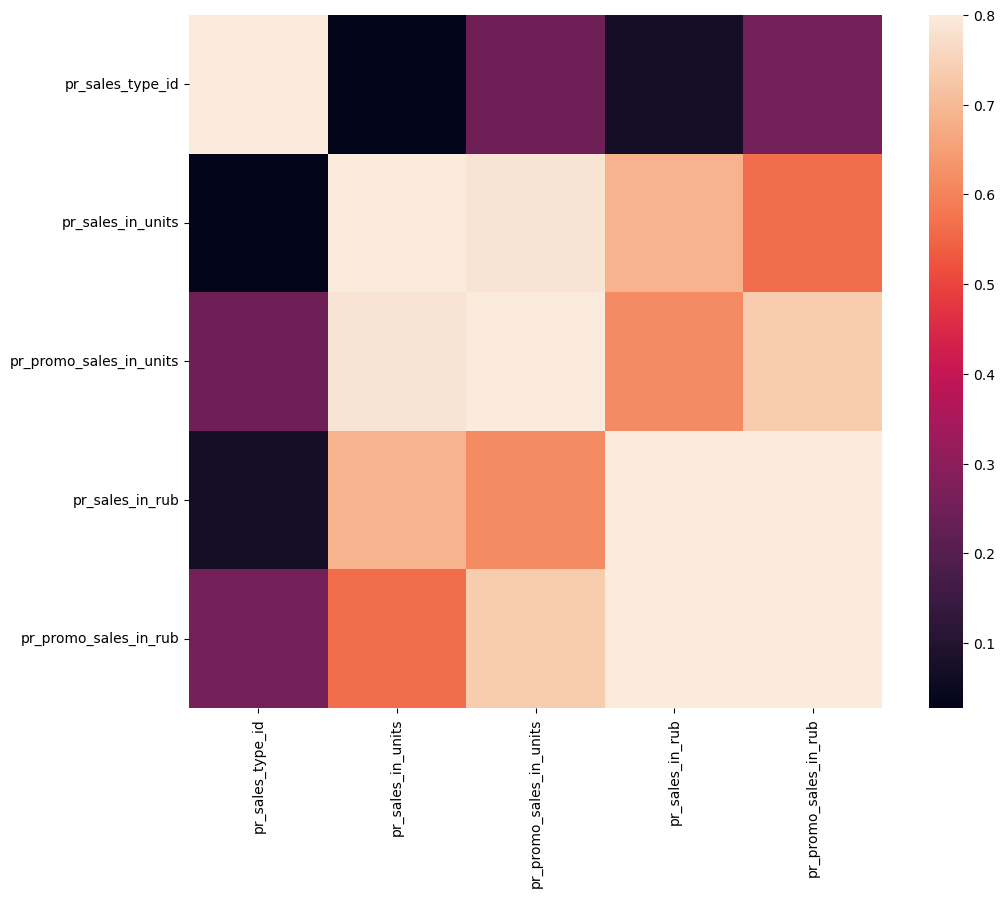

In [13]:
corrmat = sales.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);

In [14]:
sales.rename(columns={'st_id': 'st_id', 'date': 'date', 'pr_sku_id': 'pr_sku_id', 'pr_sales_type_id': 'pr_sales_type_id',
                     'pr_sales_in_units': 'sales_in_units', 'pr_sales_in_rub': 'sales_in_rub'}, inplace=True)

sales.drop(['pr_promo_sales_in_units', 'pr_promo_sales_in_rub'], axis=1, inplace=True)

sales.shape

(882936, 6)

На данном этапе с предобработкой продаж закончили. Переходим к следующим дата-фреймам 

In [15]:
inactive = stores[stores['st_is_active'] == 0]
inactive

,st_id,st_city_id,st_division_code,st_type_format_id,st_type_loc_id,st_type_size_id,st_is_active
0,1aa057313c28fa4a40c5bc084b11d276,1587965fb4d4b5afe8428a4a024feb0d,81b4dd343f5880df806d4c5d4a846c64,4,3,19,0
10,62f91ce9b820a491ee78c108636db089,1587965fb4d4b5afe8428a4a024feb0d,81b4dd343f5880df806d4c5d4a846c64,4,3,32,0


Два неактивных магазина. Удалим данные по их продажам из основной таблицы sales

In [16]:
sales = sales.query('st_id != "1aa057313c28fa4a40c5bc084b11d276" & st_id != "62f91ce9b820a491ee78c108636db089"')
sales.shape

(882207, 6)

## EDA

In [30]:
sales.columns

Index(['st_id', 'pr_sku_id', 'pr_sales_type_id', 'sales_in_units',
       'sales_in_rub', 'dates', 'is_holiday'],
      dtype='object')

### Анализ продаж по акции или без

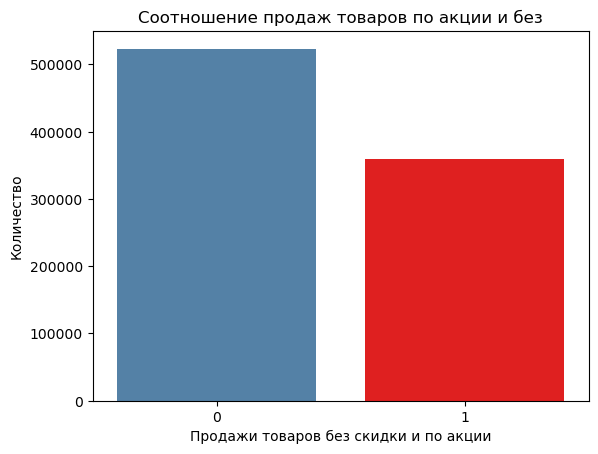

In [17]:
counts = sales['pr_sales_type_id'].value_counts()

colors = ['steelblue', 'red']

sns.barplot(x=counts.index, y=counts.values, palette=colors)

plt.xlabel('Продажи товаров без скидки и по акции')
plt.ylabel('Количество')
plt.title('Соотношение продаж товаров по акции и без')
plt.xticks(counts.index)
plt.show()


Продаж без скидки больше, чем по акции. Скорее это вызвано тем, что акции происходят не каждый день, а с определенной периодичностью. Выясним, влияют ли проведение акций на выброс в данных

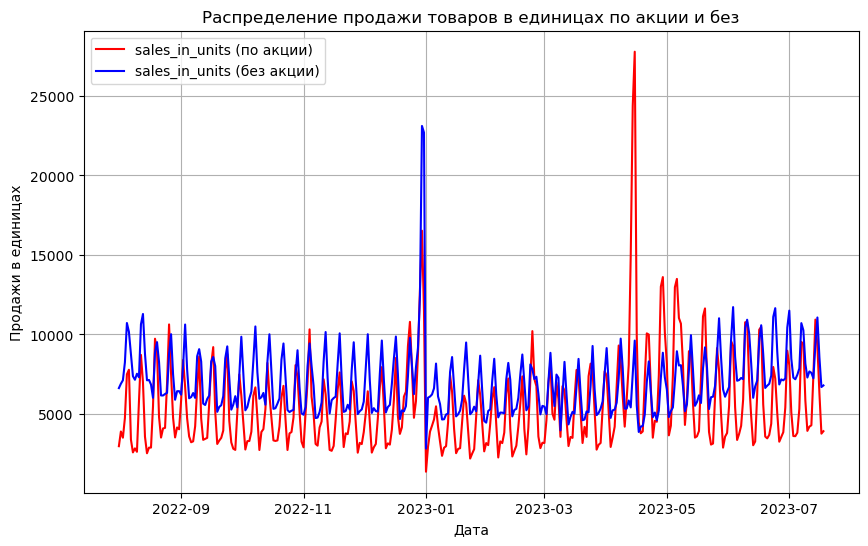

In [18]:
plt.figure(figsize=(10, 6))

# Фильтрация данных для праздничных и непраздничных дней
promo_sales = sales[sales['pr_sales_type_id'] == 1]
non_promo_sales = sales[sales['pr_sales_type_id'] == 0]

# Ресемплирование по дням для обоих случаев
promo_sales = promo_sales.resample('D').sum()
non_promo_sales = non_promo_sales.resample('D').sum()

# Построение графиков
plt.plot(promo_sales.index, promo_sales['sales_in_units'], label='sales_in_units (по акции)', color='red')
plt.plot(non_promo_sales.index, non_promo_sales['sales_in_units'], label='sales_in_units (без акции)', color='blue')

plt.title('Распределение продажи товаров в единицах по акции и без')
plt.xlabel('Дата')
plt.ylabel('Продажи в единицах')
plt.legend()
plt.grid(True)
plt.show();

Наблюдаем, что большинство выбросов продаж товаров по акции выпало на вторую половину апреля и достигло максимальных продаж за весь период. Проверим, что это за категория товаров

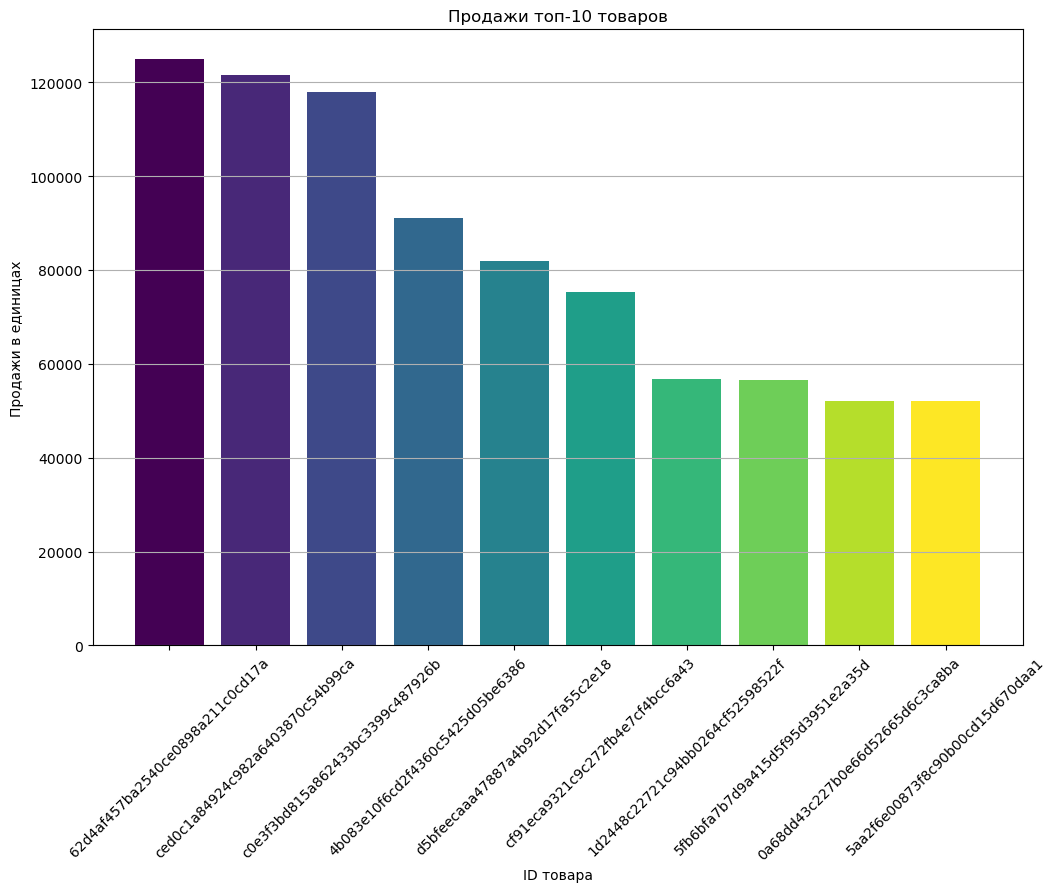

In [19]:
top_goods = sales.groupby('pr_sku_id')['sales_in_units'].sum().nlargest(10)

# Создание цветового градиента
colors = plt.cm.viridis(np.linspace(0, 1, len(top_goods)))

# Создание столбчатой диаграммы с градиентными цветами
plt.figure(figsize=(12, 8))
plt.bar(top_goods.index, top_goods.values, color=colors)

plt.title('Продажи топ-10 товаров')
plt.xlabel('ID товара')
plt.ylabel('Продажи в единицах')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

### Распределение топ 6 товаров со скользящим средним 

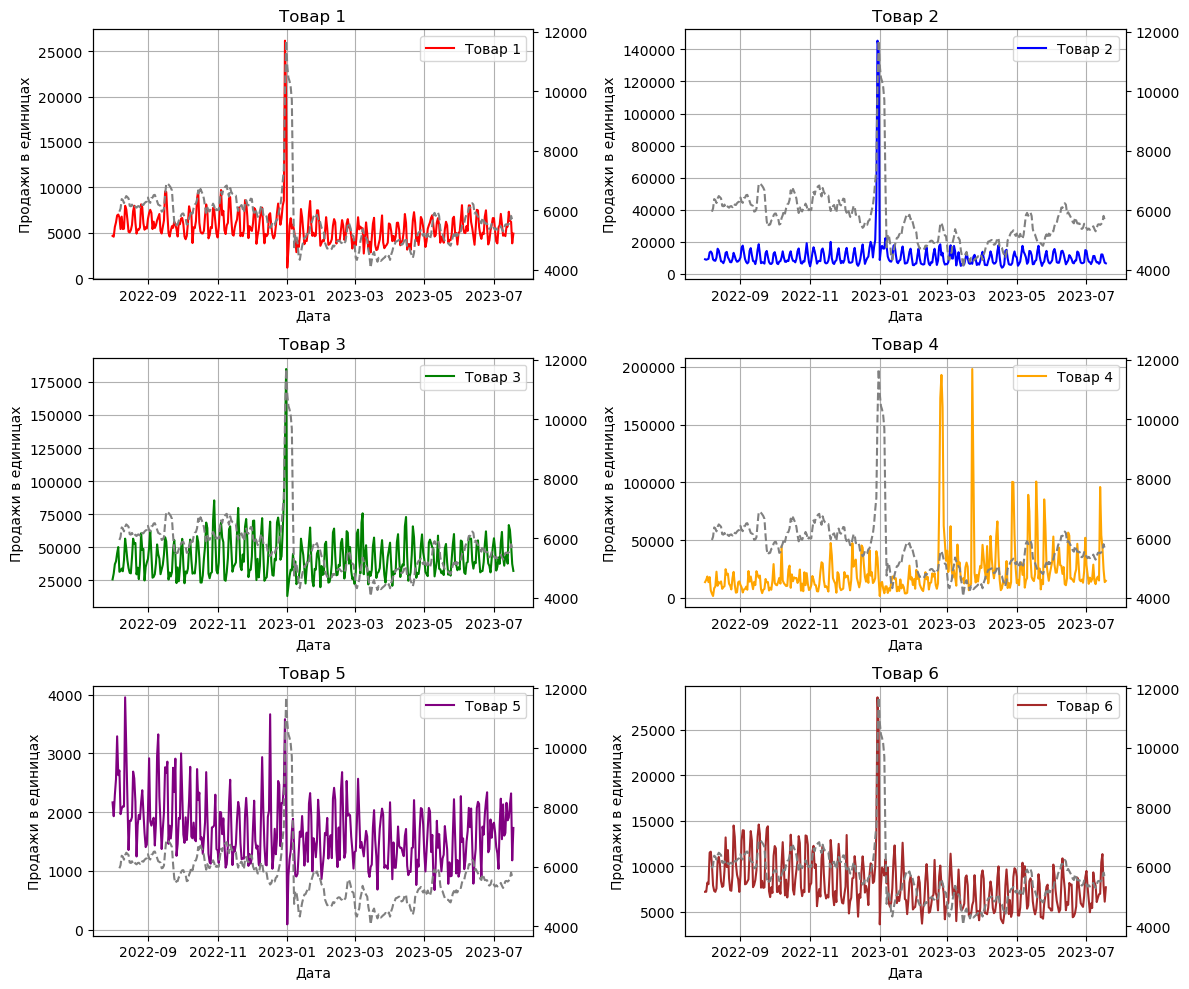

In [28]:
top_1 = sales[sales['pr_sku_id'] == '62d4af457ba2540ce0898a211c0cd17a']
top_2 = sales[sales['pr_sku_id'] == 'ced0c1a84924c982a6403870c54b99ca']
top_3 = sales[sales['pr_sku_id'] == 'c0e3f3bd815a862433bc3399c487926b']
top_4 = sales[sales['pr_sku_id'] == '4b083e10f6cd2f4360c5425d05be6386']
top_5 = sales[sales['pr_sku_id'] == 'd5bfeecaaa47887a4b92d17fa55c2e18']
top_6 = sales[sales['pr_sku_id'] == 'cf91eca9321c9c272fb4e7cf4bcc6a43']

# Ресемплирование по дням для всех случаев
top_1 = top_1.resample('D').sum()
top_2 = top_2.resample('D').sum()
top_3 = top_3.resample('D').sum()
top_4 = top_4.resample('D').sum()
top_5 = top_5.resample('D').sum()
top_6 = top_6.resample('D').sum()

# Создание сетки графиков (плитки)
num_rows = 3
num_columns = 2
fig, axes = plt.subplots(num_rows, num_columns, figsize=(12, 10))

# Построение графиков для каждого товара
tops = [top_1, top_2, top_3, top_4, top_5, top_6]
colors = ['red', 'blue', 'green', 'orange', 'purple', 'brown']
titles = ['Товар 1', 'Товар 2', 'Товар 3', 'Товар 4', 'Товар 5', 'Товар 6']

for i in range(len(tops)):
    row = i // num_columns
    col = i % num_columns
    ax = axes[row, col]
    
    ax.plot(tops[i].index, tops[i]['sales_in_rub'], label=f'Товар {i+1}', color=colors[i])
    ax.set_title(titles[i])
    ax.set_xlabel('Дата')
    ax.set_ylabel('Продажи в единицах')
    ax.grid(True)
    ax.legend()

# Убедитесь, что лишние графики скрыты, если количество товаров меньше, чем ячеек в сетке
for i in range(len(tops), num_rows * num_columns):
    row = i // num_columns
    col = i % num_columns
    axes[row, col].axis('off')
    
window_size = 7  # Размер окна для скользящего среднего
for ax in axes.flat:
    ax.grid(True)
    rolling_mean = ax.twinx()
    rolling_mean.plot(
        top_1.index, top_1['sales_in_rub'].rolling(window=window_size).mean(),
        linestyle='--', color='gray', label='Rolling Mean (top 1)'
    )

plt.tight_layout()
plt.show();

У большинство товаров пик приходится на 1 января 

### Праздничные дни

In [21]:
import holidays
russian_holidays = holidays.CountryHoliday('RU', prov=None, observed=True)

sales['is_holiday'] = sales['dates'].apply(lambda x: x in russian_holidays)

Проверка

In [22]:
date_to_check = date(2022, 9, 1)
if date_to_check in russian_holidays:
    print(f"{date_to_check} - Праздник!")
else:
    print(f"{date_to_check} - Не праздник.")

2022-09-01 - Не праздник.


In [23]:
sales['is_holiday'] = sales['is_holiday'].astype(int)
sales.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 882207 entries, 2022-10-20 to 2023-01-19
Data columns (total 7 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   st_id             882207 non-null  object 
 1   pr_sku_id         882207 non-null  object 
 2   pr_sales_type_id  882207 non-null  int64  
 3   sales_in_units    882207 non-null  float64
 4   sales_in_rub      882207 non-null  float64
 5   dates             882207 non-null  object 
 6   is_holiday        882207 non-null  int64  
dtypes: float64(2), int64(2), object(3)
memory usage: 53.8+ MB


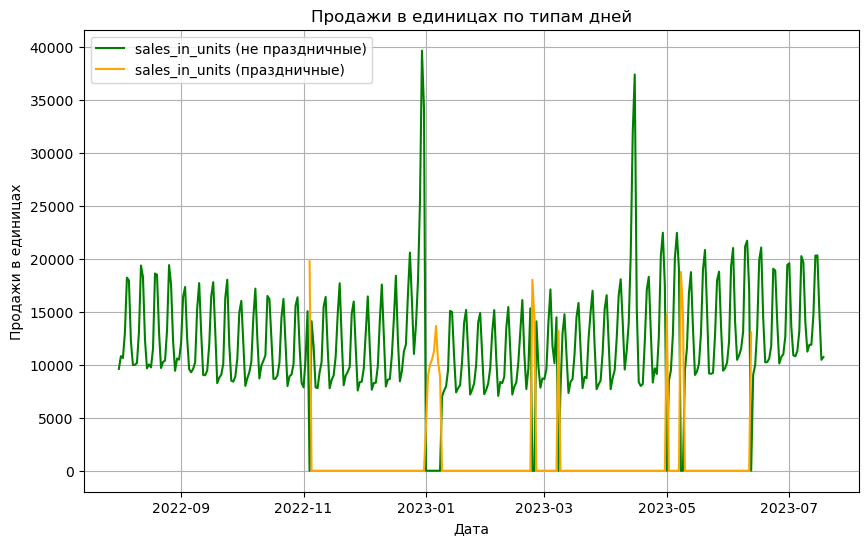

In [24]:
plt.figure(figsize=(10, 6))

# Фильтрация данных для праздничных и непраздничных дней
holiday_sales = sales[sales['is_holiday'] == 0]
non_holiday_sales = sales[sales['is_holiday'] == 1]

# Ресемплирование по дням для обоих случаев
holiday_sales = holiday_sales.resample('D').sum()
non_holiday_sales = non_holiday_sales.resample('D').sum()

# Построение графиков
plt.plot(holiday_sales.index, holiday_sales['sales_in_units'], label='sales_in_units (не праздничные)', color='green')
plt.plot(non_holiday_sales.index, non_holiday_sales['sales_in_units'], label='sales_in_units (праздничные)', color='orange')

plt.title('Продажи в единицах по типам дней')
plt.xlabel('Дата')
plt.ylabel('Продажи в единицах')
plt.legend()
plt.grid(True)
plt.show();


Наблюдаем, что пик по продажам происходит до всероссийских праздников, а не в день. Рассмотрим более детально периоды майских и новогодних праздников. Именно в эти периоды выбросы не в день праздника, а до

### Продажи в новогодний период

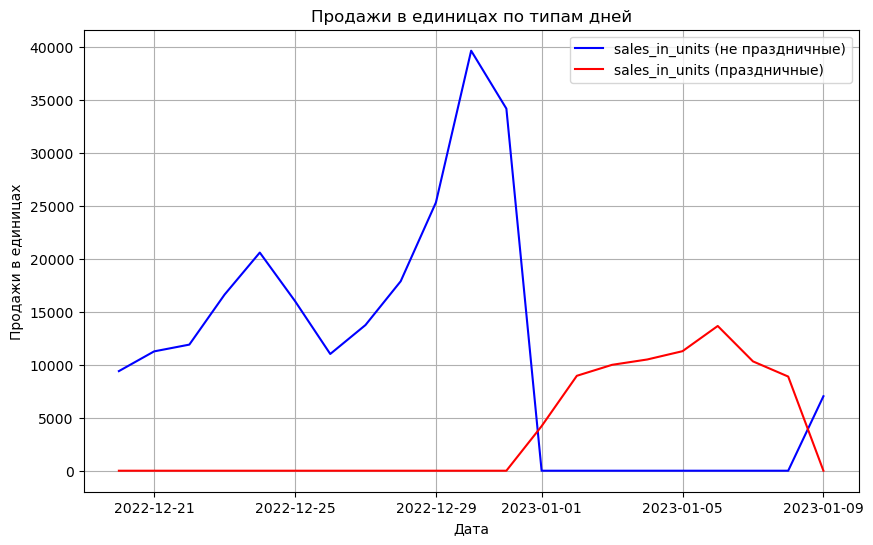

In [25]:
plt.figure(figsize=(10, 6))

# Фильтрация данных для праздничных и непраздничных дней
holiday_sales = sales[sales['is_holiday'] == 0]
non_holiday_sales = sales[sales['is_holiday'] == 1]

# Ресемплирование по дням для обоих случаев
holiday_sales = holiday_sales.resample('D').sum()
non_holiday_sales = non_holiday_sales.resample('D').sum()

# Устанавливаем период с 25 декабря 2022 по 9 января 2023
start_date = '2022-12-20'
end_date = '2023-01-09'

holiday_sales = holiday_sales[start_date:end_date]
non_holiday_sales = non_holiday_sales[start_date:end_date]

# Построение графиков
plt.plot(holiday_sales.index, holiday_sales['sales_in_units'], label='sales_in_units (не праздничные)', color='blue')
plt.plot(non_holiday_sales.index, non_holiday_sales['sales_in_units'], label='sales_in_units (праздничные)', color='red')

plt.title('Продажи в единицах по типам дней')
plt.xlabel('Дата')
plt.ylabel('Продажи в единицах')
plt.legend()
plt.grid(True)
plt.show()

### Майские праздники (1 мая)

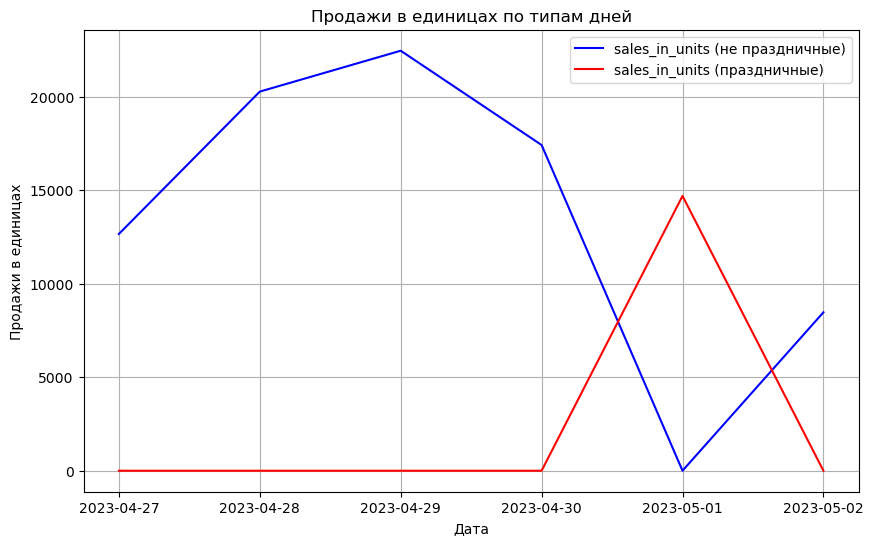

In [26]:
plt.figure(figsize=(10, 6))

# Фильтрация данных для праздничных и непраздничных дней
holiday_sales = sales[sales['is_holiday'] == 0]
non_holiday_sales = sales[sales['is_holiday'] == 1]

# Ресемплирование по дням для обоих случаев
holiday_sales = holiday_sales.resample('D').sum()
non_holiday_sales = non_holiday_sales.resample('D').sum()

# Устанавливаем период с 25 декабря 2022 по 9 января 2023
start_date = '2023-04-27'
end_date = '2023-05-02'

holiday_sales = holiday_sales[start_date:end_date]
non_holiday_sales = non_holiday_sales[start_date:end_date]

# Построение графиков
plt.plot(holiday_sales.index, holiday_sales['sales_in_units'], label='sales_in_units (не праздничные)', color='blue')
plt.plot(non_holiday_sales.index, non_holiday_sales['sales_in_units'], label='sales_in_units (праздничные)', color='red')

plt.title('Продажи в единицах по типам дней')
plt.xlabel('Дата')
plt.ylabel('Продажи в единицах')
plt.legend()
plt.grid(True)
plt.show()

### Майские праздники (9 мая)

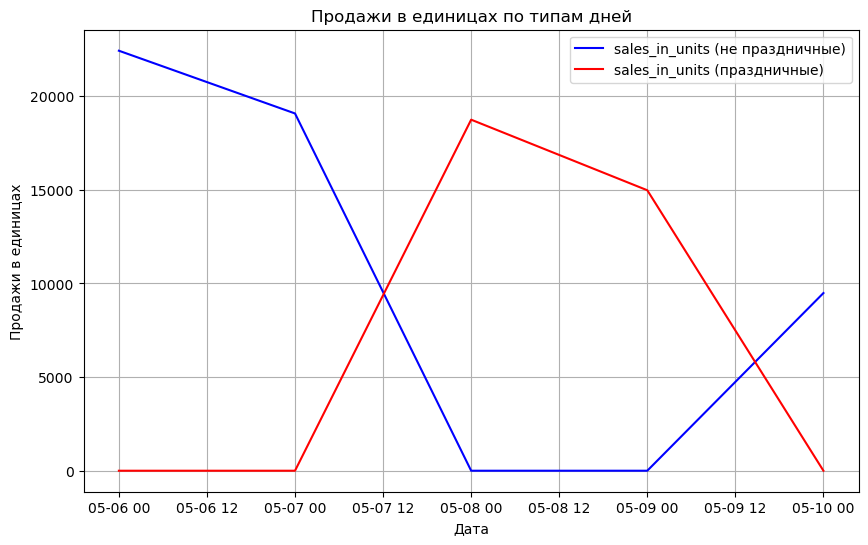

In [27]:
plt.figure(figsize=(10, 6))

# Фильтрация данных для праздничных и непраздничных дней
holiday_sales = sales[sales['is_holiday'] == 0]
non_holiday_sales = sales[sales['is_holiday'] == 1]

# Ресемплирование по дням для обоих случаев
holiday_sales = holiday_sales.resample('D').sum()
non_holiday_sales = non_holiday_sales.resample('D').sum()

# Устанавливаем период с 25 декабря 2022 по 9 января 2023
start_date = '2023-05-06'
end_date = '2023-05-10'

holiday_sales = holiday_sales[start_date:end_date]
non_holiday_sales = non_holiday_sales[start_date:end_date]

# Построение графиков
plt.plot(holiday_sales.index, holiday_sales['sales_in_units'], label='sales_in_units (не праздничные)', color='blue')
plt.plot(non_holiday_sales.index, non_holiday_sales['sales_in_units'], label='sales_in_units (праздничные)', color='red')

plt.title('Продажи в единицах по типам дней')
plt.xlabel('Дата')
plt.ylabel('Продажи в единицах')
plt.legend()
plt.grid(True)
plt.show()

Гипотеза подтвердилась. Продажи на новогодние и майские выше за день-два до праздника и снижаются в сам праздник и под конец

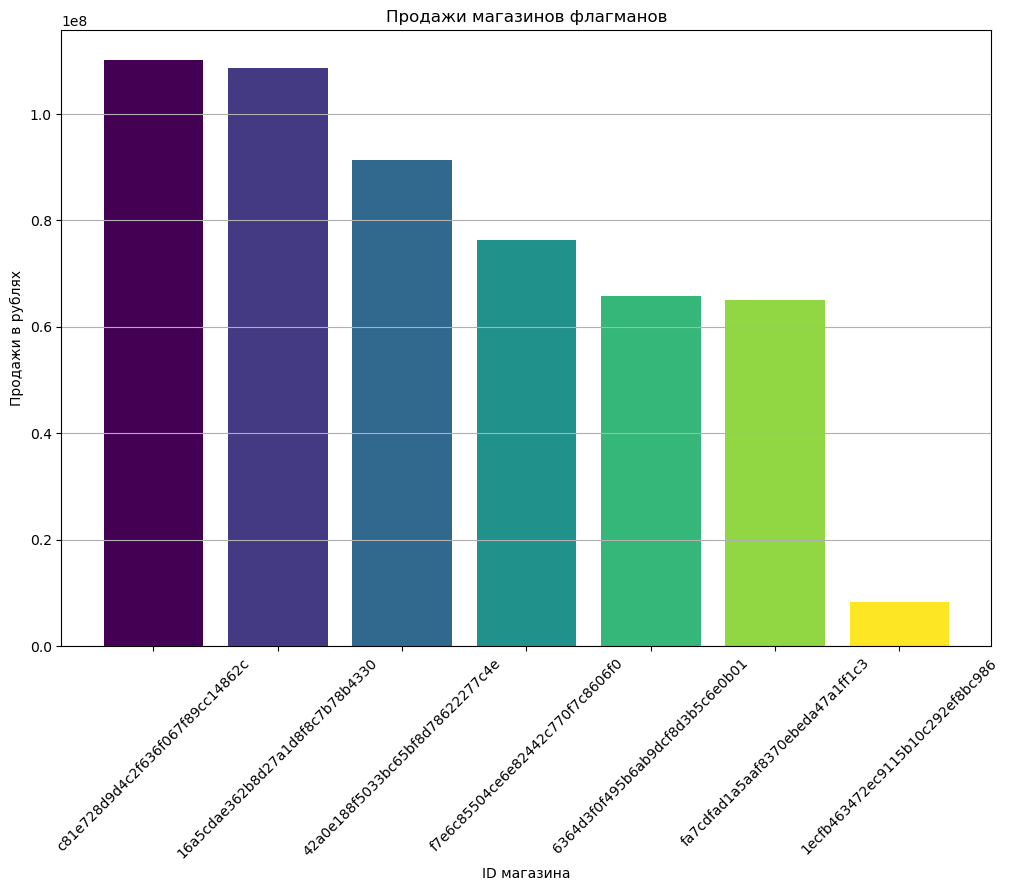

In [39]:
top_stores = sales.groupby('st_id')['sales_in_rub'].sum().nlargest(7)

# Создание цветового градиента
colors = plt.cm.viridis(np.linspace(0, 1, len(top_stores)))

# Создание столбчатой диаграммы с градиентными цветами
plt.figure(figsize=(12, 8))
plt.bar(top_stores.index, top_stores.values, color=colors)

plt.title('Продажи магазинов флагманов')
plt.xlabel('ID магазина')
plt.ylabel('Продажи в рублях')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()